In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202107'))

CONNECT_INDY = False
CONNECT_MOBILE = False
USE_SDK = True

IP_CUR = "192.168.0.10"# get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"

print("Current PC IP: {}".format(IP_CUR))
print("Mobile ROB IP: {}".format(MOBILE_IP))

Current PC IP: 192.168.0.10
Mobile ROB IP: 192.168.0.102


In [2]:
from enum import Enum
class ExpType(Enum):
    REMOVE_OBS=0
    CONTACT_TAR=1

EXP_SCENARIO = ExpType.REMOVE_OBS
USE_KIRO_TOOL = True

In [3]:
INDY_BASE_OFFSET = (0.172,0,0.439)
INDY_BASE_RPY = (0,0,0)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001
WS_HEIGHT = 1.6
COL_COLOR = (1,1,1,0.2)
    
if EXP_SCENARIO == ExpType.REMOVE_OBS: ## Obstacle removing
    BAG_COUNT = 5
    CLOCK_COUNT = 0
    TARGET_COUNT = 5
    LOG_FORCE = False
else: ## Contact 
    BAG_COUNT = 3
    CLOCK_COUNT = 3
    TARGET_COUNT = 5
    LOG_FORCE = True

from pkg.controller.combined_robot import *
from pkg.project_config import *

if not CONNECT_INDY:
    indy_7dof_client.kiro_tool.OFFLINE_MODE = True
kiro_udp_client.KIRO_UDP_OFFLINE_DEBUG = not CONNECT_MOBILE

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                "{}/{}".format(MOBILE_IP, IP_CUR))
robot_config = RobotConfig(1, RobotType.indy7, 
                           (INDY_BASE_OFFSET, INDY_BASE_RPY),
                INDY_IP, root_on="kmb0_platform", 
                           specs={"no_sdk":True} if not USE_SDK else {})

ROBOT_TYPE = robot_config.type
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[True, CONNECT_INDY])

connection command:
kmb0: True
indy1: False


### Make scene

In [4]:
from pkg.geometry.builder.scene_builder import SceneBuilder
from pkg.planning.scene import PlanningScene

s_builder = SceneBuilder(None)
gscene = s_builder.create_gscene(crob)
gtems = s_builder.add_robot_geometries(
    color=COL_COLOR, display=True, collision=True)

gscene.set_workspace_boundary(
    -1, 4, -2.5, 2.5, -CLEARANCE, WS_HEIGHT, thickness=WALL_THICKNESS)

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


### Planning scene

In [5]:
from pkg.geometry.geometry import *
from pkg.utils.code_scraps import *
from pkg.planning.constraint.constraint_subject import *
from pkg.planning.constraint.constraint_actor import *

In [6]:
pscene = PlanningScene(gscene, combined_robot=crob)
ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
CAM_LINK = TIP_LINK.replace("tcp", "link6")
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE
BRUSH_NAME = "brush_face"
if USE_KIRO_TOOL:
    from demo_utils.environment import add_kiro_indytool_down
    brush_face = add_kiro_indytool_down(gscene, zoff=0, tool_link="indy1_tcp", face_name="brush_face", ext_off=0.032, tool_dim=(0.08, 0.32))
    crob.home_pose[6:] = np.deg2rad([  0., 50.,  -70.,  -0.,  -90., 0])
    crob.home_dict = list2dict(crob.home_pose, crob.joint_names)
else:
    brush_face = add_indy_sweep_tool(
        gscene, ROBOT_NAME, face_name=BRUSH_NAME, tool_offset=0.12, color_col=(0.8,0.8,0.8,0.2), W=0.05, L=0.15)

if USE_KIRO_TOOL:
    point_brush, rpy_brush = (0,0,-brush_face.dims[2]/2), (0,0,0)
else:
    point_brush, rpy_brush = (0,0,brush_face.dims[2]/2), (0,np.pi,0)
brush_b = pscene.create_binder(BRUSH_NAME, BRUSH_NAME, WayFramer, point=point_brush, rpy=rpy_brush)
gscene.show_pose(crob.home_pose)

MOBILE_PUSH_NAME = "mpush"
MOBILE_PUSH_HEIGHT = 0.4
MOBILE_PUSH_KEY = 1
MOBILE_SLIDE_KEY = 2
front_dist = 0.46
mpush_g = gscene.create_safe(GEOTYPE.SPHERE, MOBILE_PUSH_NAME, link_name=HOLD_LINK,dims=(0.01,0.01,0.01),
                           center=(front_dist, 0, MOBILE_PUSH_HEIGHT), rpy=(0,np.pi/2,0),
                           fixed=True, collision=False, color=(1,0,0,0.5))
mpush_b = pscene.create_binder(MOBILE_PUSH_NAME, MOBILE_PUSH_NAME, FramedTool, point=(0,0,0), rpy=(0,0,0), key=MOBILE_PUSH_KEY)

floor_b = pscene.create_binder("floor_ws", "floor_ws", PlaceFrame, point=(0,0,WALL_THICKNESS/2), key=MOBILE_SLIDE_KEY)

TOOL_PUSH_NAME = "tpush"
TOOL_PUSH_HEIGHT = 0.03
TOOL_PUSH_KEY = 10
TOOL_SLIDE_KEY = 11
brush_col = gscene.NAME_DICT[BRUSH_NAME+"_col"]
TOOL_DIM = brush_col.dims

if USE_KIRO_TOOL:
    center_push, rpy_push = (TOOL_DIM[0]/2+CLEARANCE, 0, 0), (0,np.pi/2,0)
else:
    center_push, rpy_push = (-TOOL_DIM[0]/2-CLEARANCE, 0, 0), (0,-np.pi/2,0)
    
tpush_g = gscene.create_safe(GEOTYPE.SPHERE, TOOL_PUSH_NAME, link_name=TIP_LINK,dims=(0.01,0.01,0.01),
                           center=center_push, rpy=rpy_push,
                           fixed=True, collision=False, color=(1,0,0,0.5), parent=BRUSH_NAME)
tpush_b = pscene.create_binder(TOOL_PUSH_NAME, TOOL_PUSH_NAME, FramedTool, point=(0,0,0), rpy=(0,0,0), key=TOOL_PUSH_KEY)

## Table

In [7]:
TABLE_DIM = (0.6, 1.2, 0.7)
TABLE_NAME = "table"
TABLE_LOC = (3, 0, TABLE_DIM[2]/2)
TABLE_RPY = (0,0,0)

In [8]:
table_g = gscene.create_safe(GEOTYPE.BOX, TABLE_NAME, link_name="base_link", dims=TABLE_DIM,
                             center=TABLE_LOC, rpy=TABLE_RPY,
                             fixed=True, collision=True, color=(0.8,0.8,0.8,1))
table_b = pscene.create_binder(TABLE_NAME, TABLE_NAME, PlaceFrame, point=(0,0,TABLE_DIM[2]/2), key=TOOL_SLIDE_KEY)
gscene.add_virtual_guardrail(table_g, HEIGHT=0.01, axis="xy")

## Waypoints

In [9]:
WP_NAME = "wp_{}"
WP_DIM = (0.1,0.1,0.01)
WP_LOC = (-0.2, 0.0, TABLE_DIM[2]/2+WP_DIM[2]/2)
WP_RPY = (0,0,0)

In [10]:
wp_g_list = []
for i_t in range(TARGET_COUNT):
    wp_g = gscene.create_safe(GEOTYPE.BOX, WP_NAME.format(i_t), link_name="base_link", dims=WP_DIM,
                              center=(WP_LOC[0], WP_LOC[1]-0.4+i_t*0.2, WP_LOC[2]), rpy=WP_RPY,
                              fixed=True, collision=True, color=(0.0,0.0,0.8,1), parent=TABLE_NAME)
    wp_g_list.append(wp_g)
waypoint_s = pscene.create_subject(oname="waypoints", gname=TABLE_NAME, _type=WaypointTask,
                                 action_points_dict={
                                     wp_g.name: WayFrame(
                                         wp_g.name, wp_g, [0, 0, wp_g.dims[2] / 2], [0, 0, 0])
                                     for wp_g in wp_g_list
                                 })

## Clock

In [11]:
CLOCK_NAME = "clock_{}"
CLOCK_DIM = (0.14,0.05,0.076)
clock_center = np.add(wp_g.center[:2]+(0,), (0,0.1,TABLE_DIM[2]+CLOCK_DIM[2]/2+CLEARANCE))

In [12]:
for i_c in range(CLOCK_COUNT):
    CLOCK_NAME_I = CLOCK_NAME.format(i_c)
    clock_g = gscene.create_safe(GEOTYPE.BOX, CLOCK_NAME_I, link_name="base_link",dims=CLOCK_DIM,
                               center=(clock_center[0], clock_center[1]-i_c*0.4, clock_center[2]), rpy=(0,0,0),
                               fixed=False, collision=True, color=(0.8,0.5,0.3,1))

    push_point_list = []
    for i in range(4):
        R = Rot_axis_series([3, 2], [np.pi/2*i, np.pi/2])
        point = np.round(np.multiply(CLOCK_DIM, -R[:,2])/2, 4)
        point[2] = -CLOCK_DIM[2]/2 + TOOL_PUSH_HEIGHT
        ap_name = "side{}".format(i)
        push_point_list.append(FramePoint(ap_name, clock_g, point=point, rpy=Rot2rpy(R), key=TOOL_PUSH_KEY))

    if USE_KIRO_TOOL:
        dir_push = [0,0,1]
    else:
        dir_push = [-1,0,0]
    slide_point = SlidePoint("bottom_p", clock_g, point=(0,0,-CLOCK_DIM[2]/2-CLEARANCE), rpy=(0,0,0), 
                             binded_on=table_b, dist_push_min=0.1, dist_push_max=0.3, dir_push=dir_push, key=TOOL_SLIDE_KEY)

    clock_s = pscene.create_subject(oname=CLOCK_NAME_I, gname=CLOCK_NAME_I, _type=PushObject, 
                                  push_point_list=push_point_list, slide_point=slide_point)

## Bag

In [13]:
BAG_NAME = "bag_{}"
BAG_DIM = (0.4, 0.29,0.64)

In [14]:
for i_b in range(BAG_COUNT):
    BAG_NAME_I = BAG_NAME.format(i_b)
    bag_center = [1.5,0.8*(i_b-int(BAG_COUNT/2)),BAG_DIM[2]/2]
    if EXP_SCENARIO == ExpType.CONTACT_TAR:
        bag_center[1] *= 1.7
    bag_g = gscene.create_safe(GEOTYPE.BOX, BAG_NAME_I, link_name="base_link",dims=BAG_DIM,
                               center=bag_center, rpy=(0,0,0),
                               fixed=False, collision=True, color=(0.8,0.8,0.8,1))
    handle = gscene.create_safe(GEOTYPE.BOX, BAG_NAME_I+"_hdl", link_name="base_link",dims=(0.2,0.03,0.02),
                               center=(0,0,BAG_DIM[2]/2+0.01), rpy=(0,0,0),
                               fixed=False, collision=True, color=(0.6,0.6,0.6,1), parent=BAG_NAME_I)

    push_point_list = []
    for i in range(4):
        R = Rot_axis_series([3, 2], [np.pi/2*i, np.pi/2])
        point = np.round(np.multiply(BAG_DIM, -R[:,2])/2, 4)
        point[2] = -BAG_DIM[2]/2 + MOBILE_PUSH_HEIGHT
        ap_name = "side{}".format(i)
        push_point_list.append(FramePoint(ap_name, bag_g, point=point, rpy=Rot2rpy(R), key=MOBILE_PUSH_KEY))

    slide_point = SlidePoint("bottom_p", bag_g, point=(0,0,-BAG_DIM[2]/2-CLEARANCE), rpy=(0,0,0), 
                                               binded_on=floor_b, dist_push_min=0.1, dist_push_max=1.0, key=MOBILE_SLIDE_KEY)

    bag_s = pscene.create_subject(oname=BAG_NAME_I, gname=BAG_NAME_I, _type=PushObject, 
                                  push_point_list=push_point_list, slide_point=slide_point)

### prepare planner

In [15]:
from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
gcheck = GraspChecker(pscene)
rcheck = ReachChecker(pscene)

from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene, enable_dual=False)
mplan.update_gscene()
mplan.incremental_constraint_motion = True

from pkg.planning.incremental_search import *
# joint motion is not allowed when pusing object with holder
idc_push = np.where([stype == PushObject for stype in pscene.subject_type_list])[0]
inc = IncrementalSearch(pscene, gcheck, rcheck, 
                        explicit_rule= lambda pscene, node, leaf: not any([node[idx]==leaf[idx] and "push" in node[idx] for idx in idc_push]))
inc.prepare()
inc.set_motion_planner(mplan)
inc.prepare()

cresv = CollisionResolver(inc, gcheck)
rresv = ReachResolver(inc, rcheck, mplan, floor=floor_b.geometry)
mresv = MotionResolver(inc, mplan)
inc.resolver_stack = [cresv, rresv, mresv]

from pkg.ui.ui_broker import *
# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(inc, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

[WARN] reach data is not ready for kmb. Ignoring this robot...
Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)


### Plan

In [16]:
gscene.show_pose(crob.home_pose)
chain_list = \
    [BindingChain(BAG_NAME.format(i_b), "bottom_p", "floor_ws", "floor_ws") for i_b in range(BAG_COUNT)] \
    + [BindingChain(CLOCK_NAME.format(i_c), "bottom_p", "table", "table") for i_b in range(CLOCK_COUNT)] \
    + [BindingChain("waypoints", None, None, None)]
initial_state = pscene.initialize_state(crob.home_pose, chain_list=chain_list)
gscene.update_markers_all()
print(pscene.subject_name_list)
print(initial_state.node)

 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
['bag_0', 'bag_1', 'bag_2', 'bag_3', 'bag_4', 'waypoints']
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)


In [17]:
from_state = initial_state.copy(pscene)
goal_nodes = [initial_state.node[:-1]+(5,)]

inc.search(from_state, goal_nodes, max_solution_count=1,
           verbose=False, display=False, dt_vis=0.01, 
           timeout=1.0, timeout_loop=200, 
           multiprocess=True, add_homing=True)

Use 18/36 agents
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
++ adding return motion to acquired answer ++
++ adding return motion to acquired answer ++
++ adding return motion to acquired answer ++
++ adding return motion to acquired answer ++
++ adding return motion to acquired answer ++
Goal reached
++ adding return motion to acquired answer ++
++ adding return motion to acquired answer ++
++ adding return motion to acquired answer ++
++ adding return motion to acquired answer ++
Goal reached
++ adding return motion to acquired answer ++
Goal reached
Goal reached
++ adding return motion to acquired answer ++
Goal reached
++ adding return motion to acquired answer ++
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
Goal reached
++ adding return motion to acquired answer ++
++ adding return motion to acquired answer ++
======================= terminated 13: required answers acquired  (4.4/200.0) ===============

### Get snode schedule

In [18]:
snode_schedule = inc.get_best_schedule(at_home=False)
snode_schedule = inc.add_return_motion(snode_schedule[-1], initial_state=initial_state) + snode_schedule

### play schedule

In [19]:
inc.play_schedule(snode_schedule)

('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)->('floor_ws', 'mpush', 'floor_ws', 'floor_ws', 'floor_ws', 0)
('floor_ws', 'mpush', 'floor_ws', 'floor_ws', 'floor_ws', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 1)
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 1)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 2)
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 2)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 3)
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 3)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 4)
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 4)->('floor_ws', 'floor_ws', 'floor_ws', '

### Drawing node graph

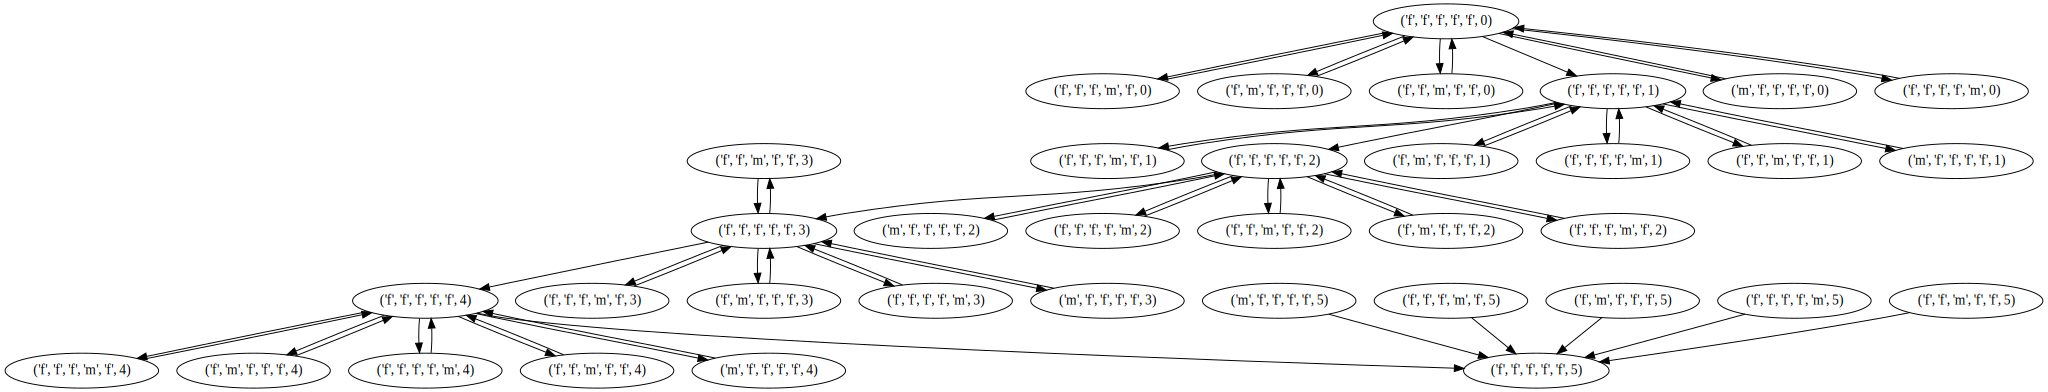

In [20]:
from pkg.utils.graph_visualize import *

vg = VisualGraph()

def simplify_node(node):
    return tuple([ntem[0] if isinstance(ntem, str) else ntem for ntem in node])

for node, leafs in inc.node_dict.items():
    vg.add_node(simplify_node(node), [simplify_node(leaf) for leaf in leafs])
    
gv = vg.draw()
# gv.save()
gv